In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

from numpy.polynomial.polynomial import polyfit

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.api as sm
import statsmodels
#import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Categorical, DataFrame, Index, MultiIndex, Panel, Series,


### First Steps

Here we are going to combine the trade and autos data set...

In [2]:
fig_path = "C:\\github\\expenditure_tradeshocks\\figures"

In [3]:
file_path = os.getcwd()
#file_path = "F:\\POLK AUTO DATA\\"

trade_county = pq.read_table(file_path + "\\data\\trade_employment_all.parquet").to_pandas()

In [4]:
trade_county["time"] = pd.to_datetime(trade_county.time)

trade_county.set_index(["area_fips", "time"],inplace = True)

In [5]:
trade_county.head(30)

total_exp_pc  china_exp_pc    tariff  emplvl_2017  \
area_fips time                                                            
10001     2017-01-01    512.529185     53.382853  1.172229       2843.0   
          2017-02-01    492.604071     43.723710  1.172278       2843.0   
          2017-03-01    560.679984     37.347986  1.172365       2843.0   
          2017-04-01    499.471573     29.463467  1.172366       2843.0   
          2017-05-01    508.584288     30.009914  1.172366       2843.0   
          2017-06-01    499.350776     26.428918  1.172366       2843.0   
          2017-07-01    482.861116     28.199912  1.172365       2843.0   
          2017-08-01    500.243692     30.920545  1.172365       2843.0   
          2017-09-01    485.835551     40.123629  1.172365       2843.0   
          2017-10-01    559.828124     69.302723  1.172365       2843.0   
          2017-11-01    561.543549     68.431336  1.172365       2843.0   
          2017-12-01    545.184928     55.044490  1.172365       2843.0   
          2018-01-01    508.771439     44.837035  1.172287       2843.0   
          2018-02-01    507.639236     40.387392  1.172372       2843.0   
          2018-03-01    578.638456     39.261744  1.172364       2843.0   
          2018-04-01    550.940726     32.838192  1.618647       2843.0   
          2018-05-01    570.086178     30.267253  1.618648       2843.0   
          2018-06-01    550.233815     25.724372  1.618648       2843.0   
          2018-07-01    517.268058     22.709404  2.658051       2843.0   
          2018-08-01    538.203378     22.653503  2.658051       2843.0   
          2018-09-01    503.607799     18.887739  2.671780       2843.0   
          2018-10-01    555.839818     22.324031  2.931847       2843.0   
          2018-11-01    548.307689     22.488479  2.851468       2843.0   
          2018-12-01    518.410176     21.394456  2.851468       2843.0   
          2019-01-01    521.269401     27.129946  2.849199       2843.0   
          2019-02-01    498.847293     31.295510  2.848524       2843.0   
          2019-03-01    566.896475     33.364345  2.848460       2843.0   
          2019-04-01    534.509388     25.752972  2.848459       2843.0   
          2019-05-01    546.931214     31.870304  2.848458       2843.0   
          2019-06-01    520.400377     35.623348  2.848457       2843.0   

                       fips  total_employment  emply_month  
area_fips time                                              
10001     2017-01-01  10001           29514.0          0.0  
          2017-02-01  10001           29514.0          0.0  
          2017-03-01  10001           29514.0          0.0  
          2017-04-01  10001           29514.0          0.0  
          2017-05-01  10001           29514.0          0.0  
          2017-06-01  10001           29514.0          0.0  
          2017-07-01  10001           29514.0          0.0  
          2017-08-01  10001           29514.0          0.0  
          2017-09-01  10001           29514.0          0.0  
          2017-10-01  10001           29514.0          0.0  
          2017-11-01  10001           29514.0          0.0  
          2017-12-01  10001           29514.0          0.0  
          2018-01-01  10001           29514.0          0.0  
          2018-02-01  10001           29514.0          0.0  
          2018-03-01  10001           29514.0          0.0  
          2018-04-01  10001           29514.0          0.0  
          2018-05-01  10001           29514.0          0.0  
          2018-06-01  10001           29514.0          0.0  
          2018-07-01  10001           29514.0          0.0  
          2018-08-01  10001           29514.0          0.0  
          2018-09-01  10001           29514.0          0.0  
          2018-10-01  10001           29514.0          0.0  
          2018-11-01  10001           29514.0          0.0  
          2018-12-01  10001           29514.0          0.0  
          2019-01-01  10001        

In [6]:
trade_county["log_tariff"] = np.log(1+.01*trade_county["tariff"])

trade_county["log_exp_total"] = np.log(trade_county["total_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_exp_china"] = np.log(trade_county["china_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_employment"] = np.log(trade_county["emply_month"]).replace(-np.inf, np.nan)

trade_county["const"] = 1

In [7]:
trade_county.reset_index(inplace = True)

trade_county.rename({"area_fips": "GEOFIPS"},axis = 1, inplace = True)

trade_county["state_fips"] = trade_county["GEOFIPS"].astype(str).str[0:2]

trade_county["GEOFIPS"] = trade_county["GEOFIPS"].astype(int)

In [8]:
#trade_county["log_value"] = np.log(trade_county["value"]).replace(-np.inf,np.nan)

trade_county.set_index(["GEOFIPS", "time"], inplace = True)

In [9]:
trade_county.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017   fips  \
GEOFIPS time                                                                   
10001   2017-01-01    512.529185     53.382853  1.172229       2843.0  10001   
        2017-02-01    492.604071     43.723710  1.172278       2843.0  10001   
        2017-03-01    560.679984     37.347986  1.172365       2843.0  10001   
        2017-04-01    499.471573     29.463467  1.172366       2843.0  10001   
        2017-05-01    508.584288     30.009914  1.172366       2843.0  10001   

                    total_employment  emply_month  log_tariff  log_exp_total  \
GEOFIPS time                                                                   
10001   2017-01-01           29514.0          0.0    0.011654       6.239358   
        2017-02-01           29514.0          0.0    0.011655       6.199706   
        2017-03-01           29514.0          0.0    0.011655       6.329150   
        2017-04-01           29514.0          0.0    0.011655       6.213551   
        2017-05-01           29514.0          0.0    0.011655       6.231631   

                    log_exp_china  log_employment  const state_fips  
GEOFIPS time                                                         
10001   2017-01-01       3.977490             NaN      1         10  
        2017-02-01       3.777891             NaN      1         10  
        2017-03-01       3.620279             NaN      1         10  
        2017-04-01       3.383151             NaN      1         10  
        2017-05-01       3.401528             NaN      1         10

### Summary Statistics

### Simple Cuts of the Auto Data by Tariff Exposure

Here is the strategy. First, compute the quantiles of tariff exposure for each county. Then compute year over year sales growth for each county. Note that since this is in growth rates, this takes out any county level "fixed effect" and removes any seasonal component. 

Then we will simply plot year over year sales growth, for the (mean or median) county in a particular part of the distribution of tariff exposure. For example, compare the sales growth for the counties which are the most exposed and then compare then to the counties which are the least exposed.

In [10]:
# First take growth rates

# note , I'm a bit confused about why the sorting,
# here is that because of some missing values, the resulting dateframe from the 
# first operation may be out of place, so we need to resort things to make sure that
# the time difference is correct.

trade_county["tariff_change"] = trade_county.groupby(["GEOFIPS"]).tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["log_tariff_change"] = trade_county.groupby(["GEOFIPS"]).log_tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["total_trade_growth"] = trade_county.groupby(["GEOFIPS"]).log_exp_total.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["china_trade_growth"] = trade_county.groupby(["GEOFIPS"]).log_exp_china.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

In [11]:
# Then what we will do is look at the change in the taiff distribution...

exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).tariff_change, 4 ,labels = False)

#median_exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).alt_tariff, 5 ,labels = False)

In [12]:
most_exposed = exposure[exposure == 3].index.tolist()

mid_group = exposure.isin([1,2])

med_exposed = exposure[mid_group].index.tolist()

least_exposed = exposure[exposure == 0].index.tolist()

trade_county.xs('2018-12-1', level=1).tariff_change.mean()


1.5371274693531065

In [13]:
print("Tariff Change-Most:", round(trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Midl:", round(trade_county.loc[med_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Lest:",round(trade_county.loc[least_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Mean:", round(trade_county.xs('2018-12-1', level=1).tariff_change.mean(),2))

Tariff Change-Most: 3.92
Tariff Change-Midl: 1.04
Tariff Change-Lest: 0.15
Tariff Change-Mean: 1.54


In [14]:
print("Chinese Exports 2017, (Most, Middle, Least, Mean)")

measure = "china_exp_pc"

print(round(trade_county.loc[most_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.groupby("time").agg({measure:"mean"}).loc["2017"].sum()[0],0))

Chinese Exports 2017, (Most, Middle, Least, Mean)
3720.0
1321.0
372.0
1805.0


In [15]:
print("Annual Employment, (Most, Middle, Least, Mean)")

print(round(trade_county.loc[most_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

Annual Employment, (Most, Middle, Least, Mean)
11631.0
55941.0
29668.0
38144.0


Now we will plot a comparision between those who are most exposed and those whoe are the least exposed (in terms of changes). This is basically the difference in difference by visualization.

In [16]:
trade_most = trade_county.loc[most_exposed].groupby("time").agg({"china_trade_growth":"mean"})

trade_least = trade_county.loc[least_exposed].groupby("time").agg({"china_trade_growth":"mean"})

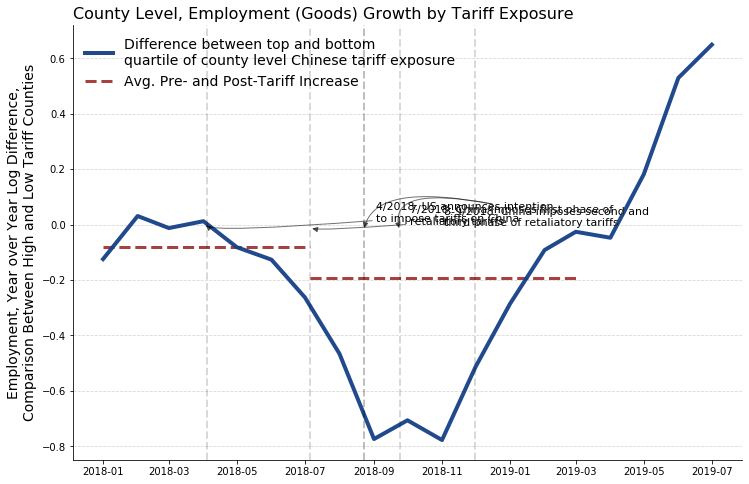

In [17]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.plot((trade_most - trade_least), alpha = 0.95, color = mike_blue, linewidth = 4, 
        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

#ax.set_ylim(-0.02,0.02)

#ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,3,1))

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.set_ylabel("Employment, Year over Year Log Difference,\nComparison Between High and Low Tariff Counties", fontsize = 14)

ax.hlines((trade_most - trade_least).loc[:"2018-07-01"].mean().iloc[0],
          dt.datetime(2018,1,1),dt.datetime(2018,7,6),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--")

ax.hlines((trade_most - trade_least).loc["2018-08-01":].mean().iloc[0],
          dt.datetime(2018,7,6),dt.datetime(2019,3,1),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--", label = "Avg. Pre- and Post-Tariff Increase")

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.25)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.legend(loc = 0, frameon  = False, fontsize = 14)

ax.set_title("County Level, Employment (Goods) Growth by Tariff Exposure", fontsize = 16, loc= "left" )

##############################################################################################

ax.annotate(
    "4/2018: US announces intention\nto impose tariffs on China", 
    xy=(dt.datetime(2018,4,3), 0.005), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,9,3), 0.01), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), -0.01), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,10,3), 0.0), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), -0.02), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), -0.02), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=286",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

#plt.savefig(fig_path + "\\simple_employment_county_all.pdf", bbox_inches = "tight", dip = 3600)

plt.show()

In [18]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

AttributeError: 'DataFrame' object has no attribute 'employment_growth'

In [ ]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

And then this creates a scatter plot of the change in growth relative to the change in tafiff

In [ ]:
def pre_post(df):
    
    idx = pd.IndexSlice
    #df["pre_tariff"] = df.car_growth.mean()
    
    #post_tariff = df.car_growth.loc["2018-07-01":].mean()
    
    pre_tariff = df.loc[idx[:,:"2018-06-01"],:].employment_growth.mean()
        
    post_tariff = df.loc[idx[:,"2018-07-01":],:].employment_growth.mean()
        
    emp_size = df.loc[idx[:,"2018-07-01":],:].emplvl_2017.mean()
    
    tariff = df.loc[idx[:,"2018-12-01"],:].tariff_change[0]
    
    foo = {"post_tariff": [post_tariff ], "pre_tariff": [pre_tariff],
           "tariff": [tariff], "size": [emp_size]}

    return pd.DataFrame(foo)

In [ ]:
growth_by_county = trade_county.groupby("GEOFIPS").apply(pre_post)

In [ ]:
growth_by_county["car_diff"] = growth_by_county.post_tariff - growth_by_county.pre_tariff

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.scatter(100*np.log(1 + .01*growth_by_county.tariff), 
           growth_by_county.car_diff, color = mike_blue,
        alpha= 0.25,s= .01*growth_by_county["size"],
          label = 'County') 

ax.set_ylabel("New Auto Sales, Year over Year Log Difference,\nComparison Between Pre and Post Tariff", fontsize = 14)

ax.set_xlabel("Change in County level Chinese Tariff Exposure", fontsize = 14)

#ax.legend(loc = 0, frameon  = False, fontsize = 12)

##########################################################################################################
all_vars = ["car_diff", 'tariff']

dataset = growth_by_county[all_vars].dropna()

model = sm.OLS(dataset.car_diff, sm.add_constant(np.log(1 + .01*dataset.tariff)))
p = model.fit().params

foo = float(p.const) + float(p.tariff)*np.log(1 + .01*dataset.tariff).sort_values()


ax.plot(100*np.log(1 + .01*dataset.tariff).sort_values(), foo,
        lw = 2, ls = "--", alpha= 0.75, color = "darkred")
#ax.scatter(test.tariff, test.post_tariff, # np.log() is taking a natural log transformation...
#            alpha= 0.15,s= .01*test["size"], color = "red") 
# Then this last command specifies how dark or light the bubbles are...

##############################################################################################

ax.annotate(
    "Best Fit Line: Slope = " + round(p.tariff,2).astype(str), 
    xy=(3, -0.05), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(4, -0.25), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)



##############################################################################################

ax.set_title("Scatter of a County's Change in Auto Sales Growth by Tariff Exposure", fontsize = 16, loc= "left" )

ax.set_ylim(-.35,.35)

ax.set_xlim(-.2,6)

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\simple_county_scatter.pdf", bbox_inches = "tight", dip = 3600)

plt.show()

In [ ]:
-0.75*(3.75-0.14)

---

### Basic Regressions


In [ ]:
trade_county.columns

### In Growth Rates

In [ ]:
all_vars = ["const", "log_tariff_change", 'total_trade_growth']

dataset = trade_county[all_vars].dropna()

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.total_trade_growth, dataset[exog_vars])

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

#df = pd.concat([dataset.employment_growth, fe_res.fitted_values],1).dropna()
#print(df.corr().iloc[0,1] ** 2)

In [ ]:
all_vars = ["const", "log_tariff_change", 'total_trade_growth']

dataset = trade_county[all_vars].dropna()

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.total_trade_growth, dataset[exog_vars], entity_effects=True, time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

In [ ]:
all_vars = ["const", "log_tariff_change", 'china_trade_growth']

dataset = trade_county[all_vars].dropna()

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.china_trade_growth, dataset[exog_vars])

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

In [27]:
all_vars = ["const", "log_tariff_change", 'total_trade_growth','emplvl_2017']

idx = pd.IndexSlice

#weights = trade_county["emplvl_2017"].loc[idx[:,"2018-01-01":"2019-02-01"]]

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset["emplvl_2017"].to_frame()

weights.replace(to_replace = 0, value = 0.001,inplace = True)

mod = PanelOLS(dataset.total_trade_growth, dataset[exog_vars], weights = weights, entity_effects=True,
               time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:     total_trade_growth   R-squared:                        0.0185
Estimator:                   PanelOLS   R-squared (Between):              0.0420
No. Observations:               53226   R-squared (Within):               0.1039
Date:                Fri, Sep 27 2019   R-squared (Overall):              0.0798
Time:                        11:09:26   Log-likelihood                  9.79e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.923e+04
Entities:                        2957   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                 F(1,50251)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             200.82
                            

In [31]:
all_vars = ["const", "log_tariff_change", 'china_trade_growth','emplvl_2017']

idx = pd.IndexSlice

#weights = trade_county["emplvl_2017"].loc[idx[:,"2018-01-01":"2019-02-01"]]

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset["emplvl_2017"].to_frame()

weights.replace(to_replace = 0, value = 0.001,inplace = True)

mod = PanelOLS(dataset.china_trade_growth, dataset[exog_vars], weights = weights, time_effects = True,
               entity_effects=True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:     china_trade_growth   R-squared:                        0.0236
Estimator:                   PanelOLS   R-squared (Between):              0.2439
No. Observations:               53226   R-squared (Within):               0.1263
Date:                Fri, Sep 27 2019   R-squared (Overall):              0.1514
Time:                        11:12:06   Log-likelihood                   -4929.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5066.2
Entities:                        2957   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                 F(1,50251)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             199.11
                            